In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [4]:
# Install missing dependencies (if needed)
!pip install imbalanced-learn xgboost lightgbm optuna

# Install powerful EDA libraries
!pip install sweetviz
!pip install -U ydata-profiling

from ydata_profiling import ProfileReport

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import optuna  # For hyperparameter tuning
import warnings
warnings.filterwarnings("ignore")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

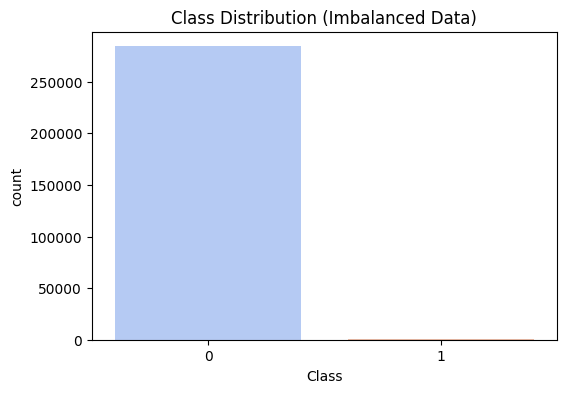

Fraudulent transactions: 0.1727%


In [5]:
# Load dataset
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

# Display basic info
print(df.info())
print(df.describe())

# Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='coolwarm')
plt.title("Class Distribution (Imbalanced Data)")
plt.show()

# Fraud percentage
fraud_percentage = df['Class'].mean() * 100
print(f"Fraudulent transactions: {fraud_percentage:.4f}%")


In [6]:
# Generate Profile Report
profile = ProfileReport(df, title="Credit Card Fraud Detection EDA", explorative=True)
profile.to_file("credit_card_fraud_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Generate Sweetviz Report
report = sv.analyze(df)
report.show_html("credit_card_fraud_sweetviz_report.html")


                                             |          | [  0%]   00:00 -> (? left)

Report credit_card_fraud_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


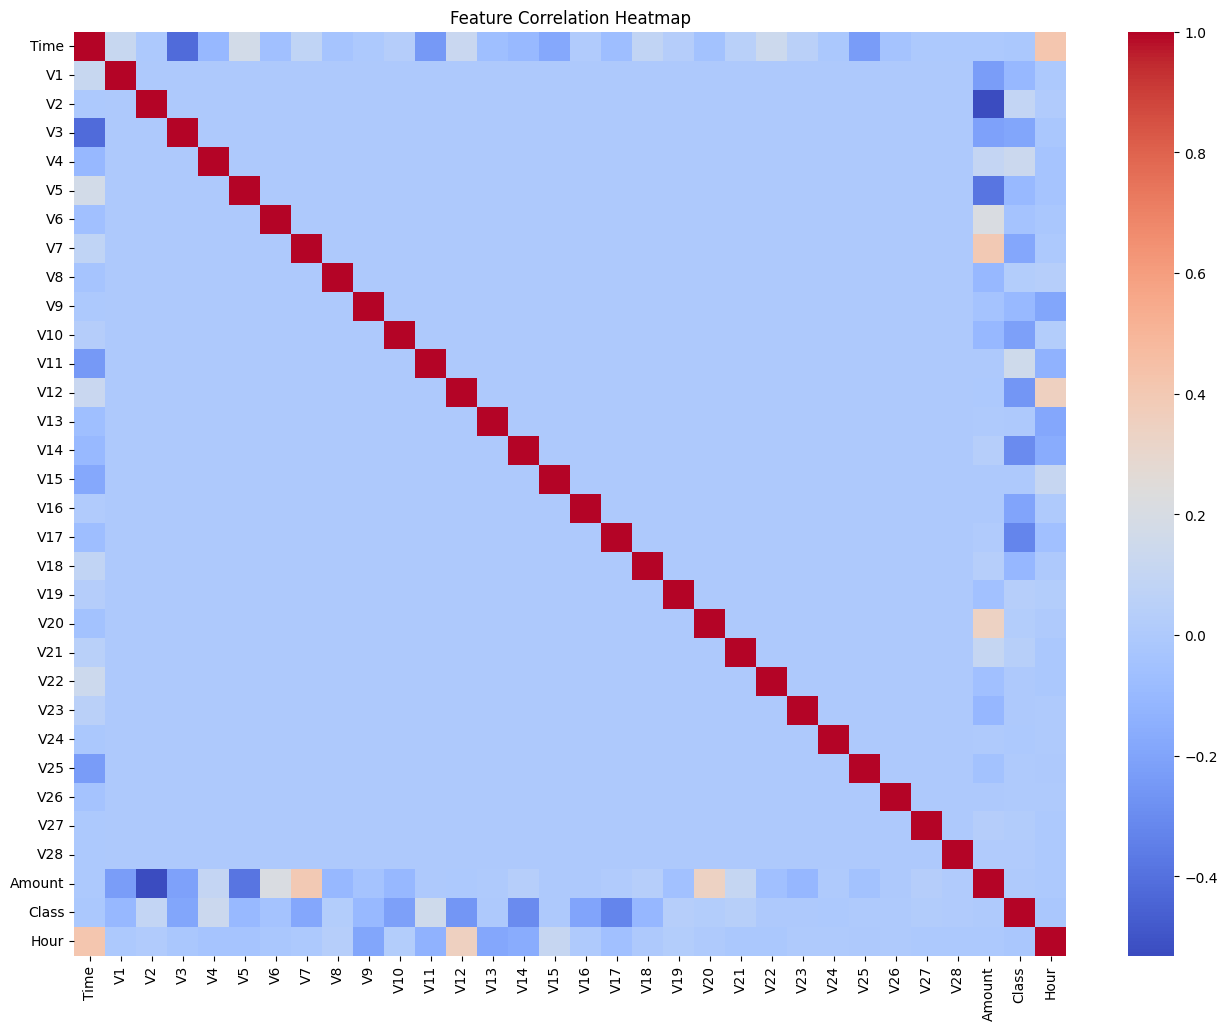

In [14]:
# Correlation heatmap
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


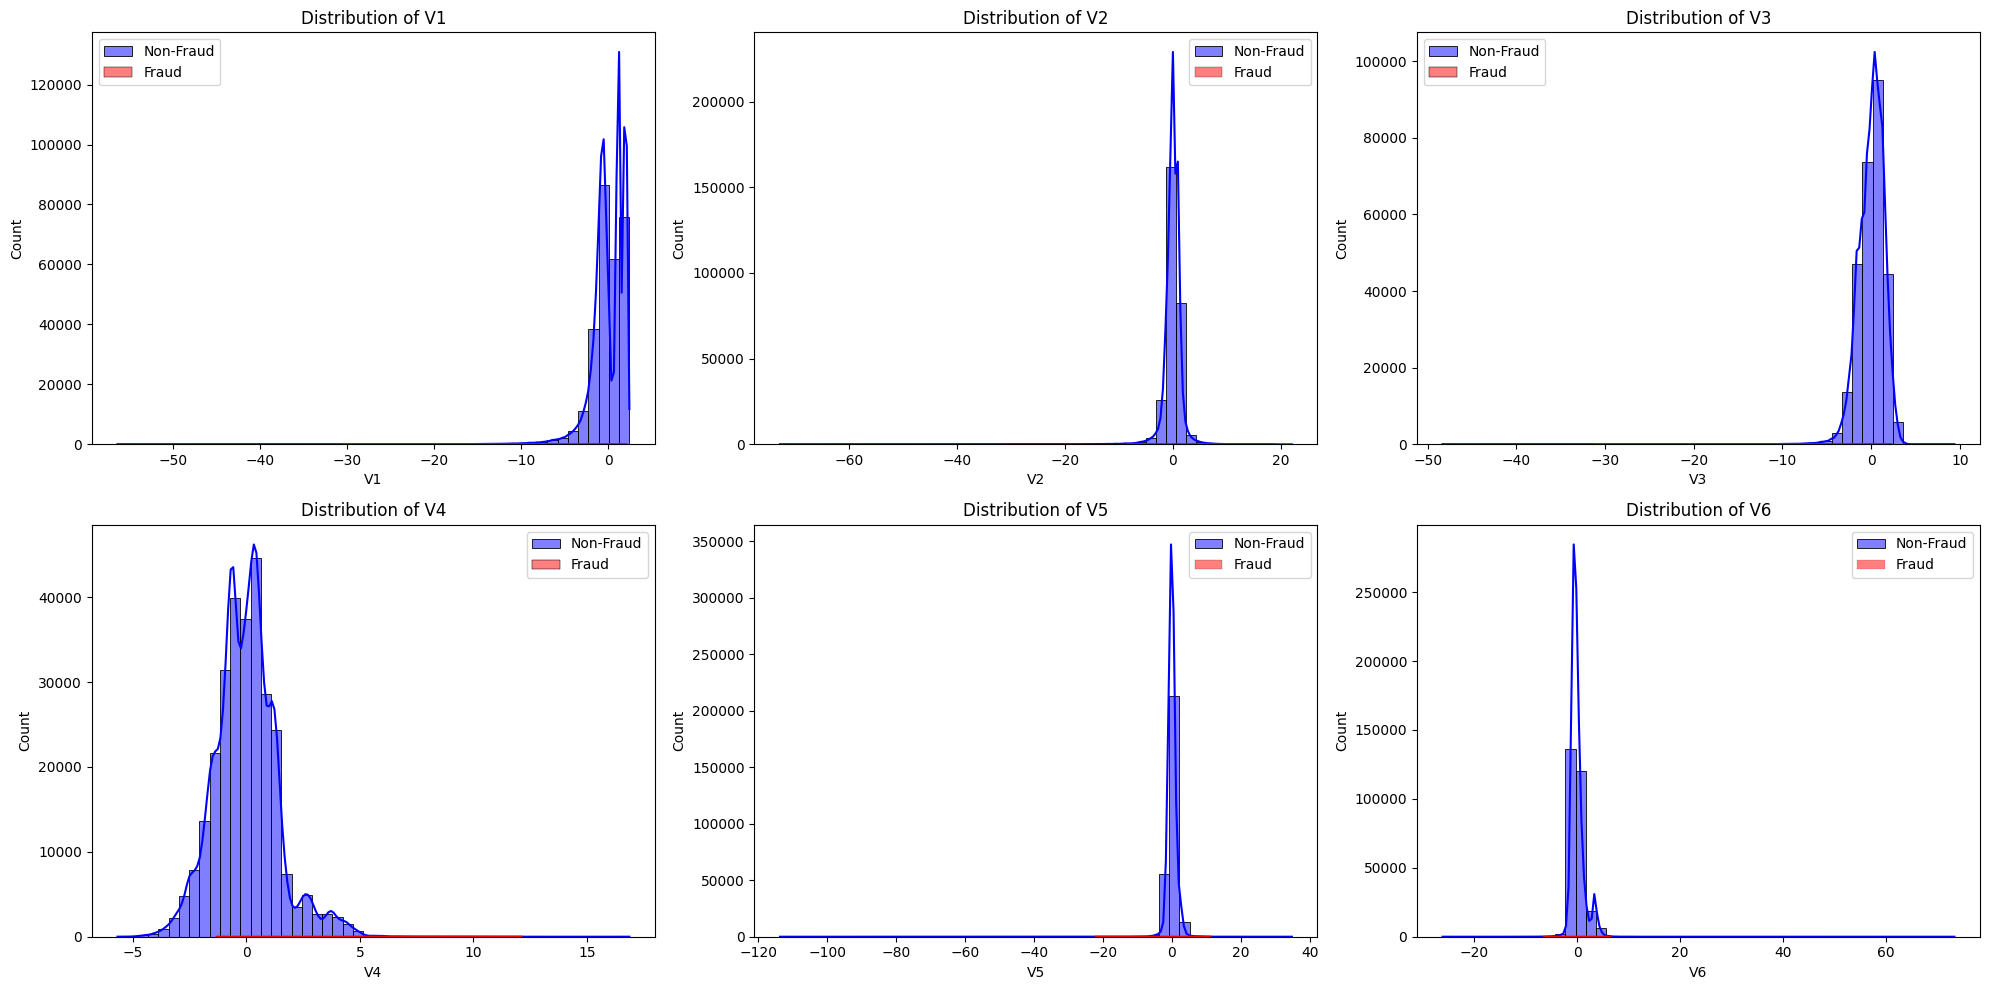

In [ ]:
# Visualizing key numerical features for fraud vs. non-fraud
plt.figure(figsize=(20,10))
for i, col in enumerate(['V1', 'V2', 'V3', 'V4', 'V5', 'V6']):
    plt.subplot(2,3,i+1)
    sns.histplot(df[df['Class']==0][col], color='blue', label='Non-Fraud', kde=True, bins=50)
    sns.histplot(df[df['Class']==1][col], color='red', label='Fraud', kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Standardizing Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (227845, 30), Test size: (56962, 30)


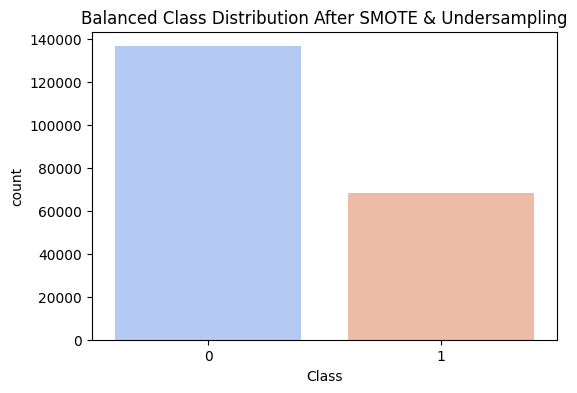

In [8]:
# Apply SMOTE and Undersampling in a pipeline
oversample = SMOTE(sampling_strategy=0.3, random_state=42)  # Oversample minority class
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Undersample majority class

pipeline = Pipeline([
    ('oversample', oversample),
    ('undersample', undersample)
])

X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

# Check new class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_balanced, palette='coolwarm')
plt.title("Balanced Class Distribution After SMOTE & Undersampling")
plt.show()


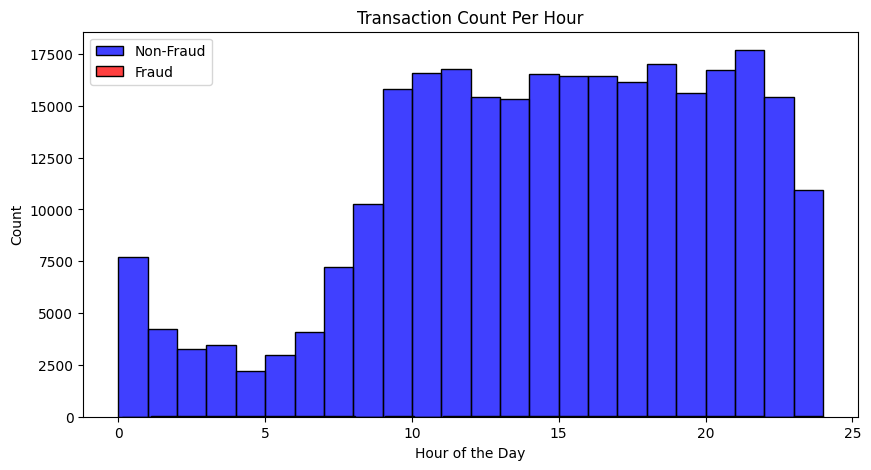

In [12]:
# Convert 'Time' feature to hours
df['Hour'] = (df['Time'] / 3600) % 24

# Transaction count per hour
plt.figure(figsize=(10,5))
sns.histplot(df[df['Class']==0]['Hour'], color='blue', label='Non-Fraud', bins=24)
sns.histplot(df[df['Class']==1]['Hour'], color='red', label='Fraud', bins=24)
plt.title("Transaction Count Per Hour")
plt.xlabel("Hour of the Day")
plt.legend()
plt.show()


In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lgbm', LGBMClassifier())
]

# Define meta-learner
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Train stacking model
stacking_model.fit(X_train_balanced, y_train_balanced)

# Predict & Evaluate
y_pred_stacking = stacking_model.predict(X_test)
auc_stacking = roc_auc_score(y_test, y_pred_stacking)

print("\nStacking Model Performance:")
print(classification_report(y_test, y_pred_stacking))
print(f"AUC-ROC Score: {auc_stacking:.4f}")


[LightGBM] [Info] Number of positive: 68235, number of negative: 136470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 204705, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 54588, number of negative: 109176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 163764, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGB

In [9]:
# Define models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

# Train models and evaluate
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC Score: {auc:.4f}")



RandomForest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.86      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9284

XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.85      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9231
[LightGBM] [Info] Number of positive: 68235, number of negative: 136470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

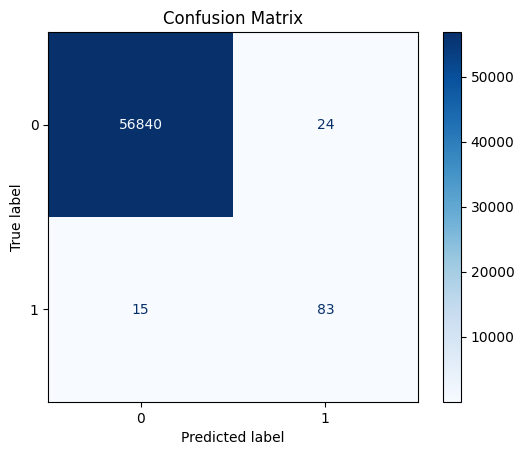

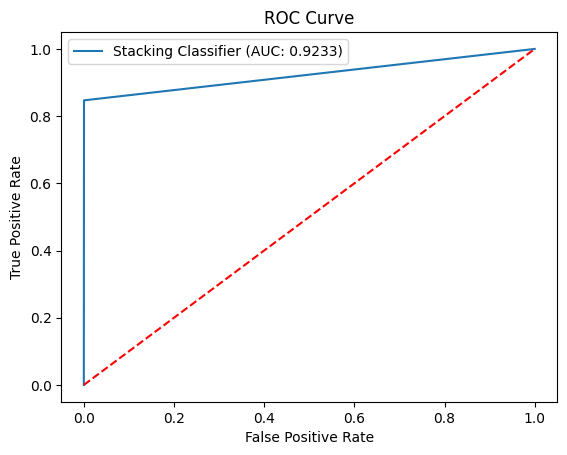

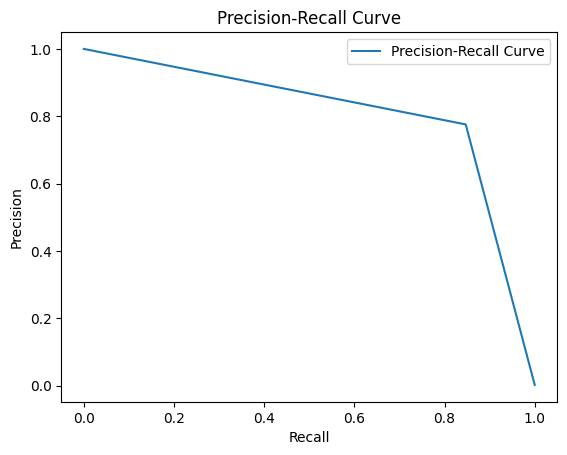

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_stacking)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_stacking)
plt.plot(fpr, tpr, label=f"Stacking Classifier (AUC: {auc_stacking:.4f})")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_stacking)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
